# ODEs with JAX

A big benefit of using JAX to write our statistical models is that we
don’t have to use specialised HMC optimised ODE software. As long as an
ODE solving library is generally JAX-compatible, we can use it in our
Bayesian statistical models.

In practice there are two main choices:
[probdiffeq](https://pnkraemer.github.io/probdiffeq/) and
[diffrax](https://docs.kidger.site/diffrax/). Here we’ll focus on
diffrax, as we (Teddy, Nick and Sergi) have more experience with it.

We’ll use diffrax to solve the initial value problem introduced in the
last session, then embed this solution inside a statistical model.

## imports

In [1]:
import arviz as az
import diffrax
import numpy as np
import jax

from jax import numpy as jnp
from matplotlib import pyplot as plt

### Specify true parameters

In order to avoid doing too much annoying handling of strings we assume
that all the parts of the problem have meaningful 1-indexed integer
labels: for example, species 1 is biomass.

This code specifies the dimensions of our problem.

In [2]:
N_strain = 4
N_tube = 16
N_timepoint = 50
duration = 30
strains = [i + 1 for i in range(N_strain)]
tubes = [i + 1 for i in range(N_tube)]
species = ["biomass", "substrate"]
measurement_timepoints = np.array([4.0, 7.0, 12.0, 15.0, 17.0])
timepoints = jnp.linspace(0.01, duration, N_timepoint)

To generate random numbers with JAX we need to explicitly create some
random key objects.

In [3]:
SEED = 12345
key = jax.random.key(seed=SEED)
rng_key, key = jax.random.split(key)
rng_key_a, rng_key_b, rng_key_c, rng_key_d = jax.random.split(rng_key, 4)

This code defines some true values for the parameters - we will use
these to generate fake data. Note that we avoid putting any constrained
variables in the parameters using some log transformations.

In [4]:
a_mu_max = -1.7
log_t_mu_max = jnp.log(0.2)
a_ks = -1.3
a_mu_max = -1.7
a_gamma = -0.6
tau_mu_max = 0.2
tau_ks = 0.3
tau_gamma = 0.13
target_conc_init = jnp.array([-2.1, 0.2])
target_conc_init_scale = jnp.array([0.1, 0.05])

true_params = {
    "a_mu_max": a_mu_max,
    "a_ks": a_ks,
    "a_gamma": a_gamma,
    "log_tau_mu_max": jnp.log(tau_mu_max),
    "log_tau_ks": jnp.log(tau_ks),
    "log_tau_gamma": jnp.log(tau_gamma),
    "log_conc_init": target_conc_init
    + target_conc_init_scale
    * jax.random.normal(
        key=rng_key_a,
        shape=(N_strain, 2),
    ),
    "log_sigma": jnp.log(jnp.array([0.08, 0.1])),
    "log_mu_max": a_mu_max
    + tau_mu_max * jax.random.normal(rng_key_b, shape=(N_strain,)),
    "log_ks": a_ks + tau_ks * jax.random.normal(rng_key_c, shape=(N_strain,)),
    "log_gamma": a_gamma
    + tau_gamma
    * jax.random.normal(
        rng_key_d,
        shape=(N_strain,),
    ),
}

def get_strain_params(strain_ix, params):
    def slice(leaf):
        return (
            leaf[strain_ix]
            if (hasattr(leaf, "shape") and leaf.ndim > 0 and leaf.shape[0] == N_strain)
            else leaf
        )

    return jax.tree.map(slice, params)

true_params_strain_2 = get_strain_params(2, true_params)

### Defining the dynamics

To implement our model using diffrax, we need to write down the dynamics
as a Python function with a special signature `t, y, args`, where `t` is
a float representing the time, `y` is a jax array of state variables and
`args` is an arbitrary auxiliary
[PyTree](https://docs.jax.dev/en/latest/pytrees.html), in this case a
dictionary of parameters pertaining to a strain.

In [5]:
def monod_kinetics(t, y, args):
    x, s = y
    mu_max = jnp.exp(args["log_mu_max"])
    ks = jnp.exp(args["log_ks"])
    gamma = jnp.exp(args["log_gamma"])
    mu = (mu_max * s) / (ks + s)
    return jnp.array([mu * x, -gamma * mu * x])

The next step is to wrap this function using the diffrax class `ODETerm`

In [6]:
monod_term = diffrax.ODETerm(monod_kinetics)

Now we can choose a solver, stepsize controller, initial sensitivity and
time points, then simulate

In [7]:
monod_term = diffrax.ODETerm(monod_kinetics)
solver = diffrax.Kvaerno5()
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
t0 = 0.0
tf = timepoints[-1]
dt0 = 0.001
y0 = jnp.exp(true_params_strain_2["log_conc_init"])
saveat = diffrax.SaveAt(ts=timepoints)
solution = diffrax.diffeqsolve(
    monod_term,
    solver,
    t0=t0,
    t1=tf,
    dt0=dt0,
    y0=y0,
    saveat=saveat,
    args=true_params_strain_2,
    stepsize_controller=stepsize_controller,
)

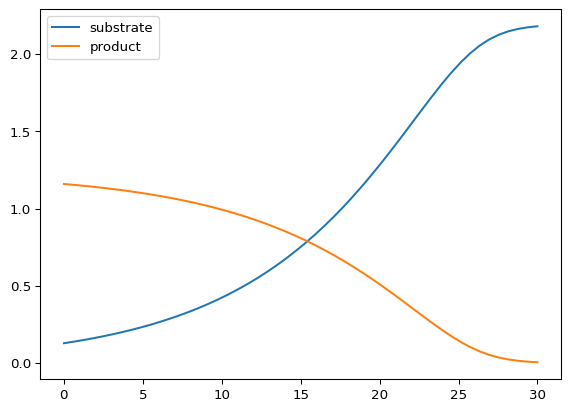

In [8]:
f, ax = plt.subplots()
for yi, label in zip(solution.ys.T, ["substrate", "product"]):
  ax.plot(timepoints, yi, label=label)
ax.legend()

nice!